# heatmap nmf

In [1]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph
from sklearn.decomposition import NMF

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [15]:
nr_nodes = 200

#G = nx.watts_strogatz_graph(nr_nodes, 10, 0.1, seed=42)
G = nx.barabasi_albert_graph(nr_nodes, m=2)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

In [3]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [21]:
def overlap_generator(G):
    """
    Function to generate a neighbourhood overlap matrix (second-order proximity matrix).
    :param G: Graph object.
    :return laps: Overlap matrix.
    """
    #print("Second order proximity calculation.\n")
    degrees = nx.degree(G)
    sets = {node:set(G.neighbors(node)) for node in nx.nodes(G)}
    laps = np.array([[float(len(sets[node_1].intersection(sets[node_2])))/(float(degrees[node_1]*degrees[node_2])**0.5) if node_1 != node_2 else 0.0 for node_1 in nx.nodes(G)] for node_2 in nx.nodes(G)],dtype = np.float64)
    return laps

In [22]:
def nmf_emb(G, dimensions, seed, eta=0.5, beta=0.):
    A = nx.to_numpy_matrix(G)
    eta = eta
    beta = beta
    S_0 = overlap_generator(G)
    R = np.random.rand(G.number_of_nodes(), G.number_of_nodes())

    S = eta*S_0 + A + beta*R
    model = NMF(n_components=dimensions, init='random', random_state=seed)
    W = model.fit_transform(S)
    H = model.components_
    return W

In [31]:
dimensions = [10]
eta = [2**i for i in range(-3, 5)]
beta = [2**i for i in range(-3, 5)]

In [32]:
args_list = []

nr_experiments = 10

for d in dimensions:
    for e in eta:
        for b in beta:
            for seed in range(nr_experiments):
                args = [d, e, b, seed]
                args_list.append(args)

In [33]:
def run_experiment(*args):
    d, e, b, seed = args
    G_emb =  nmf_emb(G, dimensions=d,  
                        eta=e, beta=b,
                        seed=seed+int(1000*(e)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [34]:
result = list(map(lambda x: run_experiment(*x), args_list))

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [39]:
df = pd.DataFrame(result, columns=['d', 'eta', 'beta', 'seed', 'hom'])
df.head()

,d,eta,beta,seed,hom
0,10,0.125,0.125,0,1.033143
1,10,0.125,0.125,1,0.949469
2,10,0.125,0.125,2,0.990482
3,10,0.125,0.125,3,1.093325
4,10,0.125,0.125,4,1.062818


In [40]:
df2 = df.groupby(['eta', 'beta'])['hom'].mean().unstack()

In [41]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


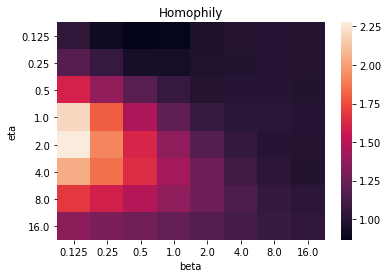

In [44]:
sns.heatmap(df2)
plt.title('Homophily')
plt.savefig('Plots/heatmap_nmf.pdf')